In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, TimeDistributed, RepeatVector, Reshape

# Data preparation

## Upload data

In [ ]:
FOLDER_PATH = "./drive/MyDrive/ColabData/IS-data/"

In [ ]:
df = pd.concat([pd.read_csv(FOLDER_PATH + "DailyDelhiClimateTrain.csv"), pd.read_csv(FOLDER_PATH + "DailyDelhiClimateTest.csv")])

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by=["date"], inplace=True)

## Explore data for possible empty values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1576 non-null   datetime64[ns]
 1   meantemp      1576 non-null   float64       
 2   humidity      1576 non-null   float64       
 3   wind_speed    1576 non-null   float64       
 4   meanpressure  1576 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 73.9 KB


In [ ]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


We see that meanpresure column has some values that are to big or to small. Decide to replace those with mean of the column.

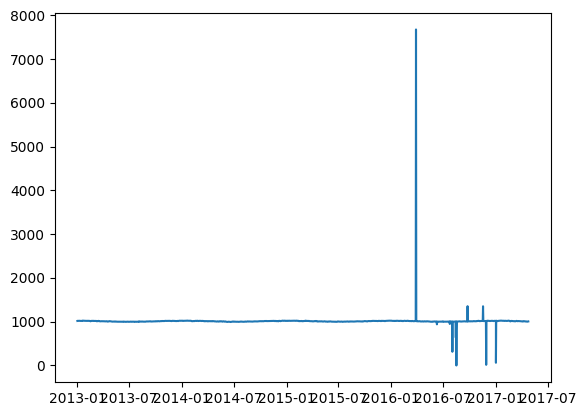

In [ ]:
plt.plot(df["date"], df["meanpressure"])

In [ ]:
mean = df["meanpressure"].astype("float").mean()
df["meanpressure"].mask(df["meanpressure"] > 1100, mean, inplace=True)
df["meanpressure"].mask(df["meanpressure"] < 980, mean, inplace=True)

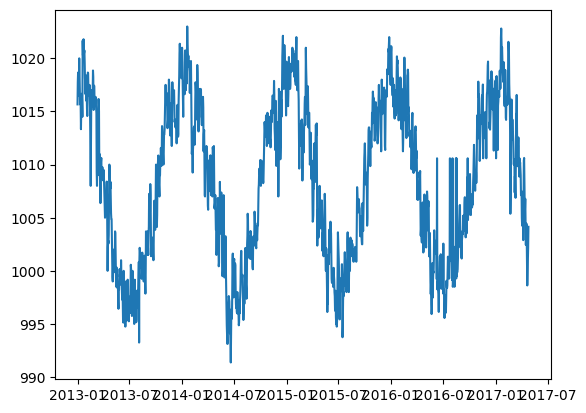

In [ ]:
plt.plot(df["date"], df["meanpressure"])

## Plot the correlation matrix

<ipython-input-11-bd08e0cb5eb5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=fig.number)


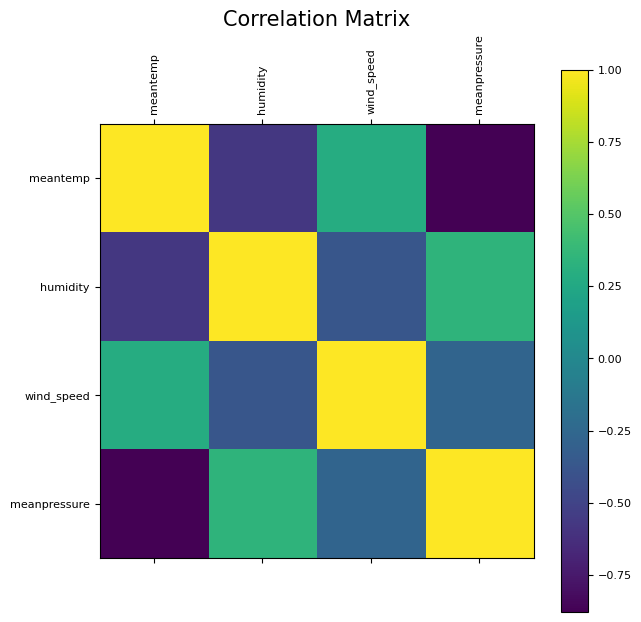

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=15);

# Develop and train models

## Univariate models

In [ ]:
def evaluate_forecasts(actual, predicted):
    rmse_by_day = [np.sqrt(mean_squared_error(actual[:, i], predicted[:, i])) for i in range(actual.shape[1])]
    overall_rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"\n----------------------\n\nOverall RMSE: {overall_rmse}\nRMSE by forecast step: {rmse_by_day}")
    return overall_rmse, rmse_by_day

In [ ]:
def create_windows(dataframe, n_input, n_output=7):
    df_values = np.array(dataframe.values)
    len_df = len(df_values)
    values, labels = [], []
    for i in range(n_input, len_df - n_output):
        values.append(df_values[i-n_input:i])
        labels.append(df_values[i:i+n_output])
    values, labels = np.array(values, dtype="float"), np.array(labels, dtype="float")
    values=np.reshape(values,(values.shape[0], values.shape[1], 1))
    return values, labels

In [ ]:
def build_and_fit_model(model_func, train, n_input, epochs, batch_size):
    X_train, y_train = create_windows(train, n_input)
    model = model_func(X_train.shape[1], X_train.shape[2], y_train.shape[1])
    model.compile(loss='mse', optimizer='adam')
    verbose = 1
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
def forecast(model, test, n_input):
    X_test, y_test = create_windows(test, n_input)
    y_pred = model.predict(X_test, verbose=1)
    score, scores = evaluate_forecasts(y_test, y_pred)
    return y_pred, score, scores

In [ ]:
def evaluate_model(model_func, train, test, n_input, epochs=10, batch_size=16):
    model = build_and_fit_model(model_func, train, n_input, epochs, batch_size)
    return forecast(model, test, n_input)

### Split data into train and test datasets

In [ ]:
def split_dataframe(dataframe, split):
    train, test = np.split(dataframe, [int(split*len(dataframe))])
    return train, test

In [ ]:
meantemp_train, meantemp_test = split_dataframe(df["meantemp"], 0.75)

In [ ]:
def plot_results_by_step(y_df, y_pred):
    _, y_actual = create_windows(y_df, 7)
    fig, axs = plt.subplots(2, 4)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    fig.delaxes(axs[1,3])
    j = 0
    for ax in axs.flatten()[:-1]:
        ax.set_title(f'{j+1} step')
        ax.plot(y_actual[:, j], label='Real temperature')
        ax.plot(y_pred[:, j], label='Predicted temperature')
        j += 1
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')
    fig.tight_layout()

### Univariate LSTM

In [ ]:
def build_uni_lstm(n_timesteps, n_features, n_outputs):
    return Sequential([
        LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)),
        Dense(50, activation='relu'),
        Dense(n_outputs)
    ])

In [ ]:
uni_lstm_preds, uni_lstm_rmse, uni_lstm_rmse_by_day = evaluate_model(build_uni_lstm, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 7s 31ms/step - loss: 143.1134
Epoch 2/10
73/73 [==============================] - 2s 27ms/step - loss: 7.1034
Epoch 3/10
73/73 [==============================] - 2s 22ms/step - loss: 6.3810
Epoch 4/10
73/73 [==============================] - 2s 25ms/step - loss: 6.3603
Epoch 5/10
73/73 [==============================] - 2s 26ms/step - loss: 5.8955
Epoch 6/10
73/73 [==============================] - 2s 21ms/step - loss: 6.0441
Epoch 7/10
73/73 [==============================] - 1s 12ms/step - loss: 5.6856
Epoch 8/10
73/73 [==============================] - 1s 11ms/step - loss: 5.5550
Epoch 9/10
73/73 [==============================] - 1s 16ms/step - loss: 5.6386
Epoch 10/10
12/12 [==============================] - 0s 6ms/step

----------------------

Overall RMSE: 2.755470156752653
RMSE by forecast step: [2.2797017029818165, 2.4555589909405042, 2.9976137229329822, 2.9315049179946038, 3.0108786460910975, 2.755592756401757, 2.77189644538

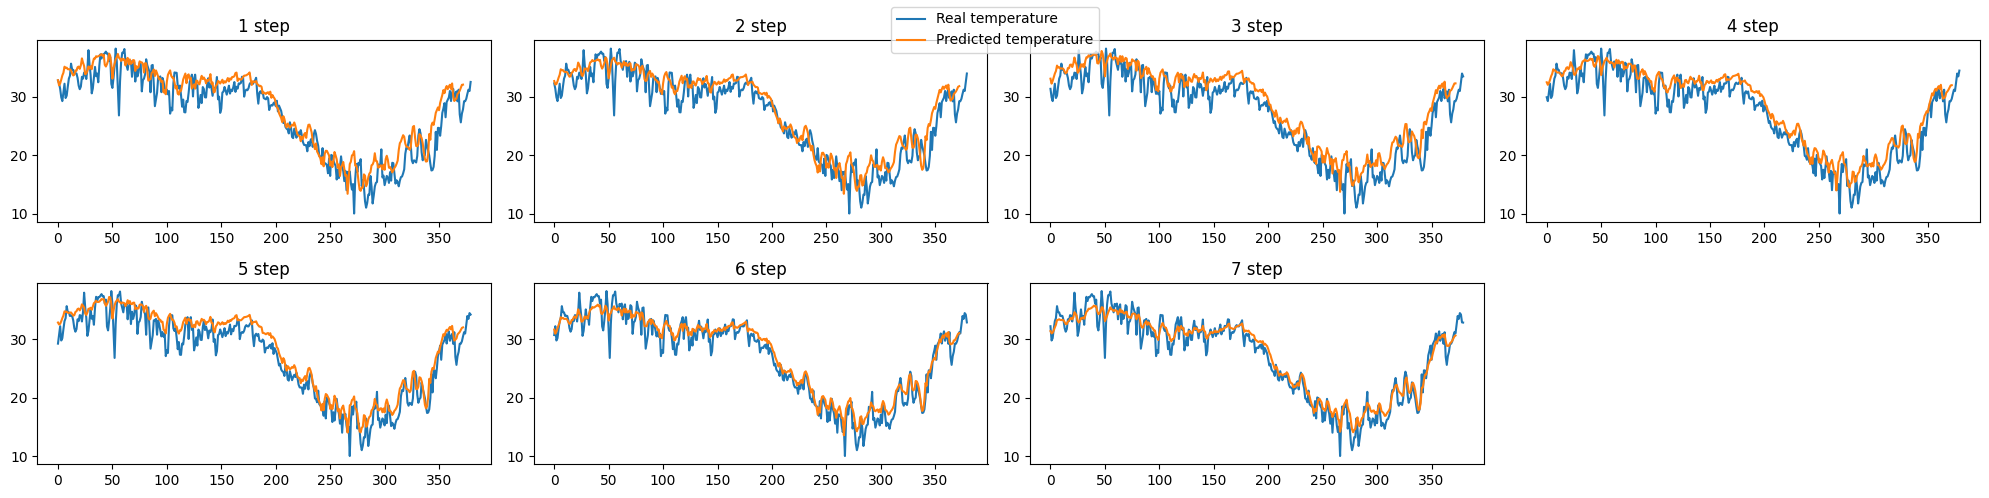

In [ ]:
plot_results_by_step(meantemp_test, uni_lstm_preds)

### Univariate GRU

In [ ]:
def build_uni_gru(n_timesteps, n_features, n_outputs):
    return Sequential([
        GRU(100, activation='relu', input_shape=(n_timesteps, n_features)),
        Dense(50, activation='relu'),
        Dense(n_outputs)
    ])

In [ ]:
uni_gru_preds, uni_gru_rmse, uni_gru_rmse_by_day = evaluate_model(build_uni_gru, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 3s 10ms/step - loss: 163.7056
Epoch 2/10
73/73 [==============================] - 1s 11ms/step - loss: 6.1863
Epoch 3/10
73/73 [==============================] - 1s 11ms/step - loss: 6.1545
Epoch 4/10
73/73 [==============================] - 1s 10ms/step - loss: 6.1156
Epoch 5/10
73/73 [==============================] - 1s 11ms/step - loss: 6.1607
Epoch 6/10
73/73 [==============================] - 1s 10ms/step - loss: 6.2448
Epoch 7/10
73/73 [==============================] - 1s 10ms/step - loss: 6.1598
Epoch 8/10
73/73 [==============================] - 1s 10ms/step - loss: 6.1642
Epoch 9/10
73/73 [==============================] - 1s 11ms/step - loss: 5.9836
Epoch 10/10
12/12 [==============================] - 0s 6ms/step

----------------------

Overall RMSE: 2.493346360894816
RMSE by forecast step: [1.9243739170986596, 2.19900883782765, 2.467980459153688, 2.6145098306482777, 2.5993311754093384, 2.697725828607254, 2.83156163255326

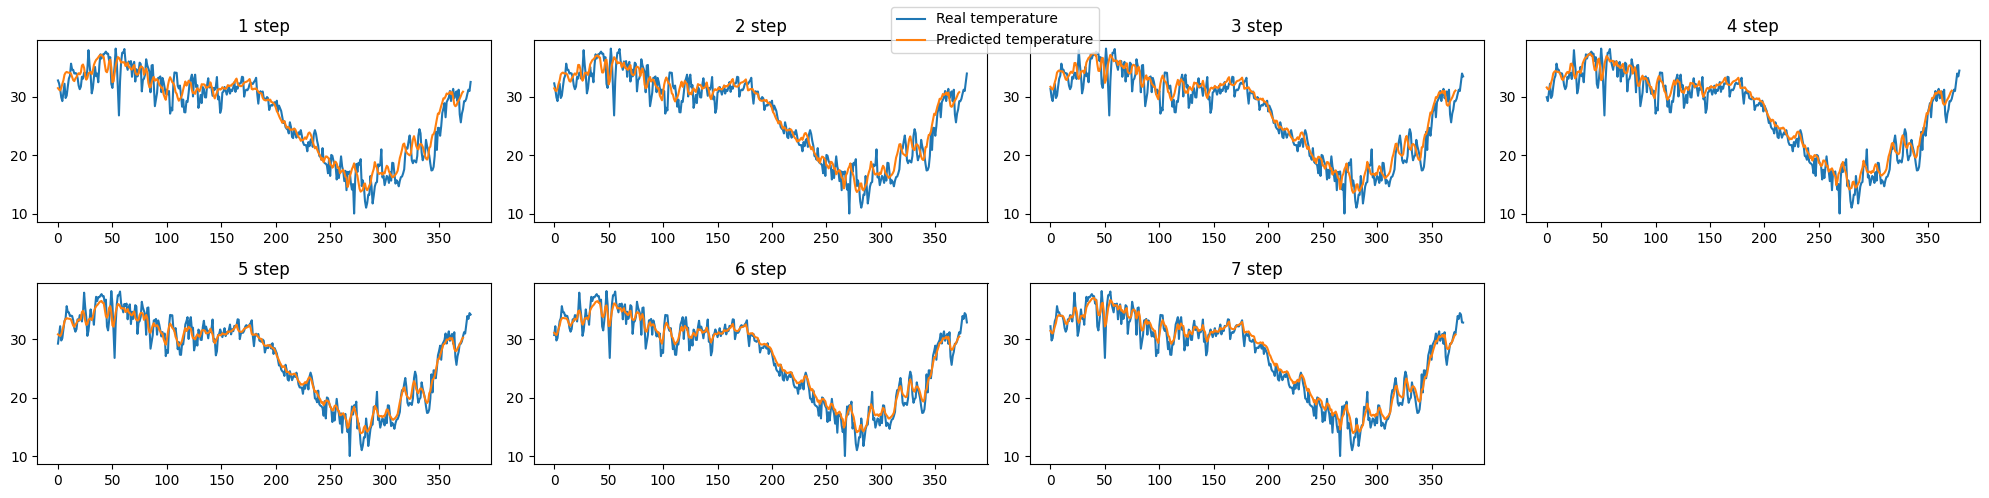

In [ ]:
plot_results_by_step(meantemp_test, uni_gru_preds)

### Univariate Encoder-Decoder LSTM

In [ ]:
def build_enc_dec_lstm(n_timesteps, n_features, n_outputs):
    return Sequential([
        LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)),
        RepeatVector(n_outputs),
        LSTM(100, activation='relu', return_sequences=True),
        TimeDistributed(Dense(50, activation='relu')),
        TimeDistributed(Dense(1)),
        Reshape((n_outputs,))
    ])

In [ ]:
uni_enc_dec_lstm_preds, uni_enc_dec_lstm_rmse, uni_enc_dec_lstm_rmse_by_day = evaluate_model(build_enc_dec_lstm, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 5s 19ms/step - loss: 54.0867
Epoch 2/10
73/73 [==============================] - 1s 17ms/step - loss: 7.5685
Epoch 3/10
73/73 [==============================] - 1s 18ms/step - loss: 6.3032
Epoch 4/10
73/73 [==============================] - 1s 18ms/step - loss: 6.0265
Epoch 5/10
73/73 [==============================] - 1s 17ms/step - loss: 6.3161
Epoch 6/10
73/73 [==============================] - 2s 24ms/step - loss: 5.9124
Epoch 7/10
73/73 [==============================] - 2s 30ms/step - loss: 5.8605
Epoch 8/10
73/73 [==============================] - 2s 26ms/step - loss: 6.0562
Epoch 9/10
73/73 [==============================] - 1s 18ms/step - loss: 5.5280
Epoch 10/10
12/12 [==============================] - 0s 7ms/step

----------------------

Overall RMSE: 2.436442615389043
RMSE by forecast step: [1.8859526696071292, 2.097315935901229, 2.3385486894481944, 2.5529645406608976, 2.6189452706266074, 2.6744547401448076, 2.756845355327

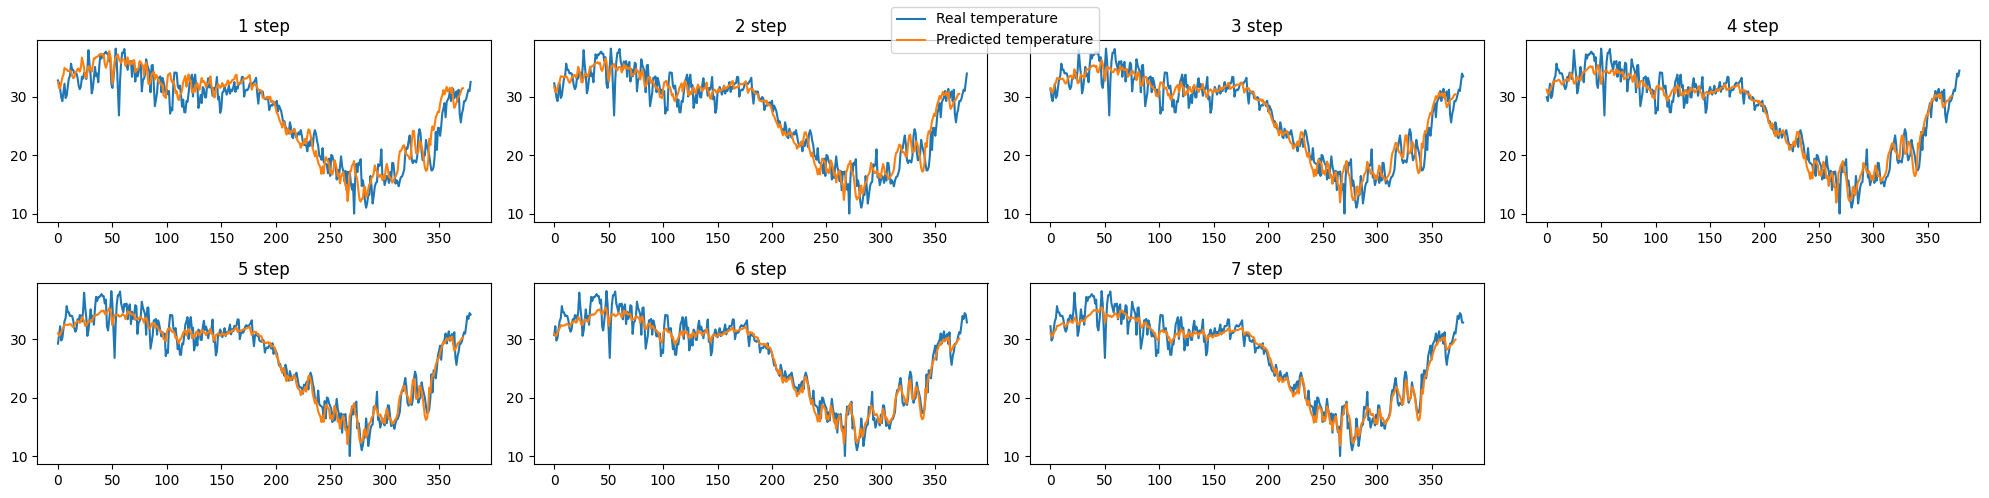

In [ ]:
plot_results_by_step(meantemp_test, uni_enc_dec_lstm_preds)

### Univariate Encoder-Decoder GRU

In [ ]:
def build_enc_dec_gru(n_timesteps, n_features, n_outputs):
    return Sequential([
        GRU(100, activation='relu', input_shape=(n_timesteps, n_features)),
        RepeatVector(n_outputs),
        GRU(100, activation='relu', return_sequences=True),
        TimeDistributed(Dense(50, activation='relu')),
        TimeDistributed(Dense(1)),
        Reshape((n_outputs,))
    ])

In [ ]:
uni_enc_dec_gru_preds, uni_enc_dec_gru_rmse, uni_enc_dec_gru_rmse_by_day = evaluate_model(build_enc_dec_gru, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 5s 18ms/step - loss: 66.3438
Epoch 2/10
73/73 [==============================] - 1s 17ms/step - loss: 5.7935
Epoch 3/10
73/73 [==============================] - 1s 18ms/step - loss: 5.7294
Epoch 4/10
73/73 [==============================] - 1s 18ms/step - loss: 5.9783
Epoch 5/10
73/73 [==============================] - 1s 17ms/step - loss: 5.7435
Epoch 6/10
73/73 [==============================] - 1s 17ms/step - loss: 5.6439
Epoch 7/10
73/73 [==============================] - 1s 18ms/step - loss: 5.8288
Epoch 8/10
73/73 [==============================] - 2s 28ms/step - loss: 5.9101
Epoch 9/10
73/73 [==============================] - 2s 28ms/step - loss: 5.9025
Epoch 10/10
12/12 [==============================] - 0s 7ms/step

----------------------

Overall RMSE: 2.433042265105519
RMSE by forecast step: [1.731595160699542, 2.1167458924304055, 2.3871938798912873, 2.549308108388603, 2.6137190045879812, 2.686265153738142, 2.77733932209066

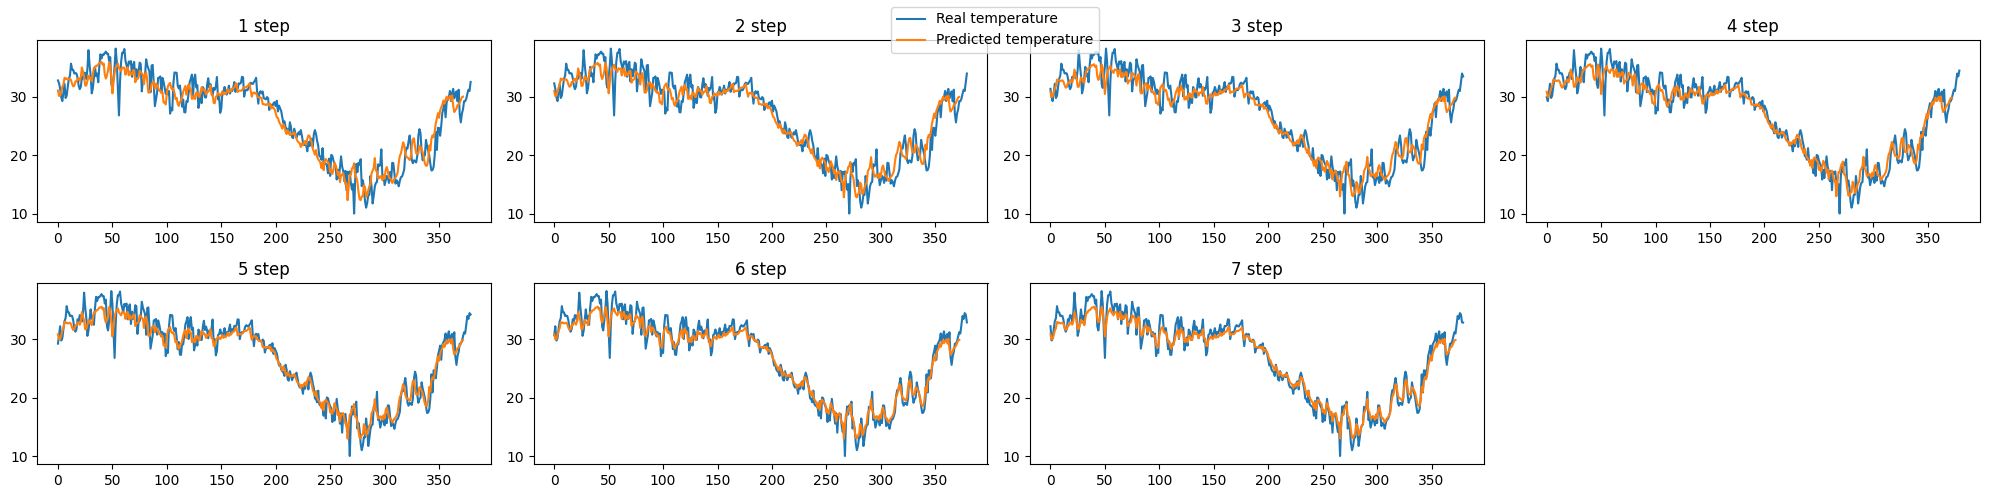

In [ ]:
plot_results_by_step(meantemp_test, uni_enc_dec_gru_preds)

## Multivariate models

In [ ]:
def create_windows(dataframe, n_input, n_output=7):
    df_values = np.array(dataframe.values)
    df_labels = np.array(dataframe["meantemp"].values)
    len_df = len(df_values)
    values, labels = [], []
    for i in range(n_input, len_df - n_output):
        values.append(df_values[i-n_input:i])
        labels.append(df_labels[i:i+n_output])
    values, labels = np.array(values, dtype="float"), np.array(labels, dtype="float")
    values=np.reshape(values,(values.shape[0], values.shape[1], 4))
    return values, labels

In [ ]:
df_train, df_test = split_dataframe(df[["meantemp", "humidity", "wind_speed", "meanpressure"]], 0.75)

### Multivariate Encoder-Decoder LSTM

In [ ]:
multi_enc_dec_lstm_preds, multi_enc_dec_lstm_rmse, multi_enc_dec_lstm_rmse_by_day = evaluate_model(build_enc_dec_lstm, df_train, df_test, 14, epochs=50)

Epoch 1/50
73/73 [==============================] - 4s 17ms/step - loss: 4446.3975
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 175.6821
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 83.9295
Epoch 4/50
73/73 [==============================] - 1s 18ms/step - loss: 37.8058
Epoch 5/50
73/73 [==============================] - 2s 21ms/step - loss: 30.2400
Epoch 6/50
73/73 [==============================] - 2s 28ms/step - loss: 25.9007
Epoch 7/50
73/73 [==============================] - 2s 28ms/step - loss: 24.4511
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 21.8023
Epoch 9/50
73/73 [==============================] - 1s 16ms/step - loss: 20.2929
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 19.4785
Epoch 11/50
73/73 [==============================] - 1s 17ms/step - loss: 17.7424
Epoch 12/50
73/73 [==============================] - 1s 17ms/step - loss: 16.8277
Epoch 13/50
73/73 [===

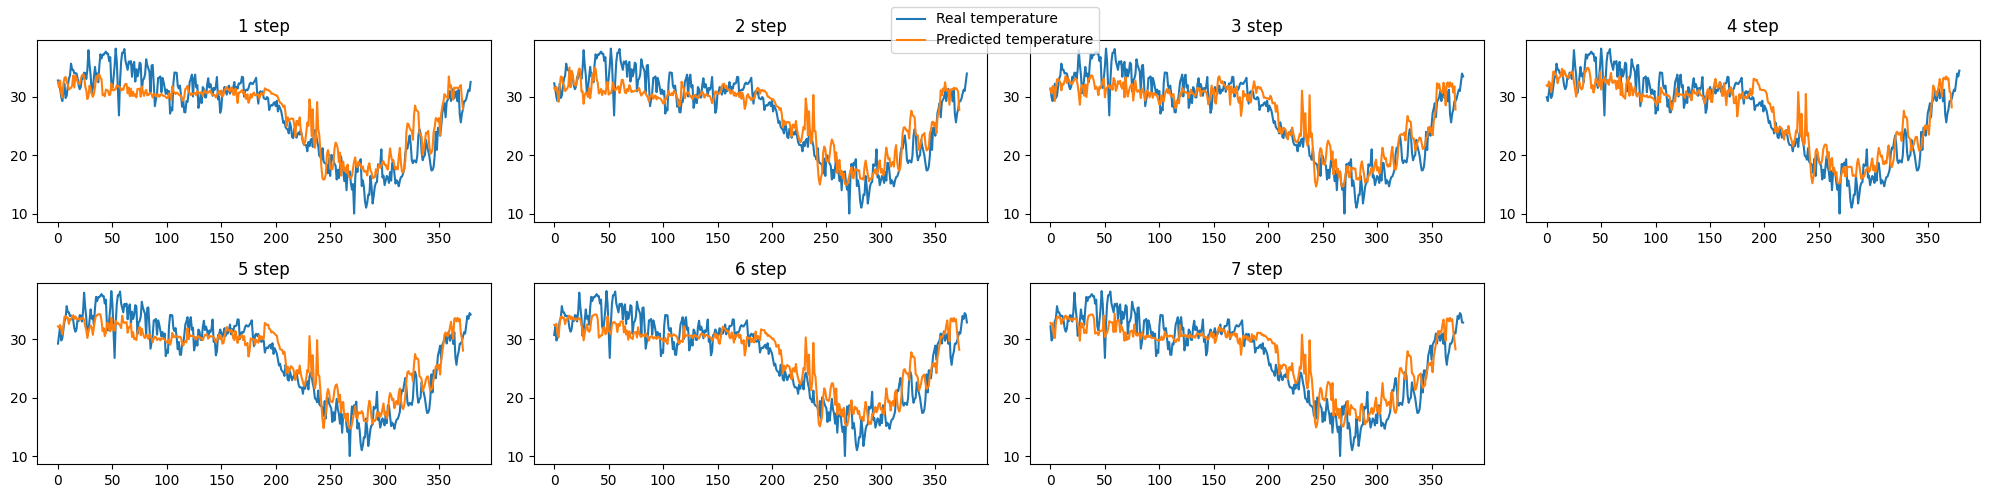

In [ ]:
plot_results_by_step(df_test, multi_enc_dec_lstm_preds)

### Multivariate Encoder-Decoder GRU

In [ ]:
multi_enc_dec_gru_preds, multi_enc_dec_gru_rmse, multi_enc_dec_gru_rmse_by_day = evaluate_model(build_enc_dec_gru, df_train, df_test, 14, epochs=50)

Epoch 1/50
73/73 [==============================] - 5s 19ms/step - loss: 169.6730
Epoch 2/50
73/73 [==============================] - 1s 18ms/step - loss: 51.0026
Epoch 3/50
73/73 [==============================] - 1s 19ms/step - loss: 50.0466
Epoch 4/50
73/73 [==============================] - 1s 19ms/step - loss: 44.2584
Epoch 5/50
73/73 [==============================] - 2s 27ms/step - loss: 30.3660
Epoch 6/50
73/73 [==============================] - 2s 30ms/step - loss: 23.2372
Epoch 7/50
73/73 [==============================] - 2s 24ms/step - loss: 16.8612
Epoch 8/50
73/73 [==============================] - 1s 19ms/step - loss: 12.7007
Epoch 9/50
73/73 [==============================] - 1s 20ms/step - loss: 15.3745
Epoch 10/50
73/73 [==============================] - 1s 20ms/step - loss: 11.6017
Epoch 11/50
73/73 [==============================] - 1s 19ms/step - loss: 8.0564
Epoch 12/50
73/73 [==============================] - 1s 19ms/step - loss: 8.1589
Epoch 13/50
73/73 [=======

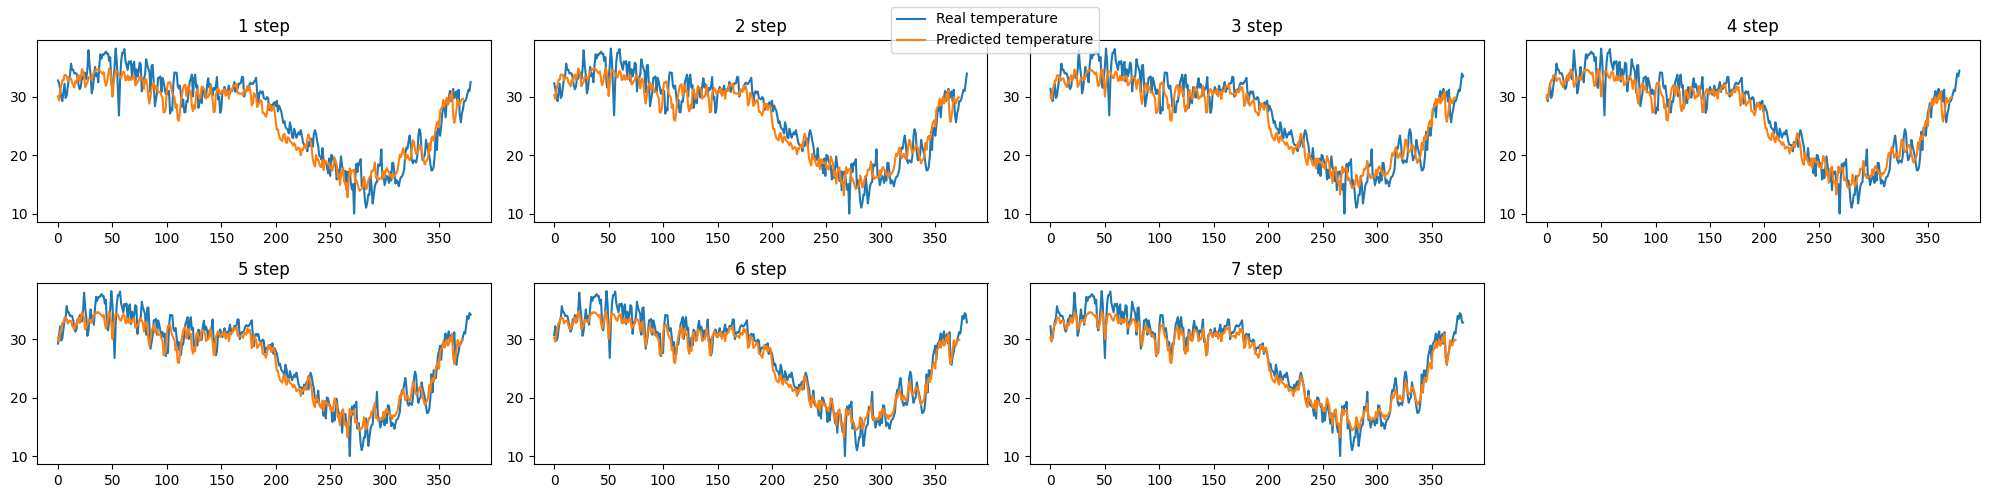

In [ ]:
plot_results_by_step(df_test, multi_enc_dec_gru_preds)